In [20]:
import pandas as pd
import csv
import nltk
import pickle
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectPercentile, f_classif
import keras
import tensorflow as tf
from keras import Input
from keras import optimizers
from keras import backend as K
import torch
from keras import regularizers
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import make_blobs
from keras.models import Sequential
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D 
from keras.utils import plot_model
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from itertools import chain
import seaborn as sns
from matplotlib import rcParams
from sklearn.model_selection import train_test_split

In [21]:
#OPEN DATA from pickle files
#x_train, x_test, y_train, y_test

with open('x_train.pkl', 'rb') as file:
    x_train = pickle.load(file)
    
with open('x_test.pkl', 'rb') as file:
    x_test = pickle.load(file)

with open('y_train.pkl', 'rb') as file:
    y_train = pickle.load(file)
    
with open('y_test.pkl', 'rb') as file:
    y_test = pickle.load(file)
    
with open('tweet_collection.pkl', 'rb') as file:
    tweet_collection = pickle.load(file)

In [22]:
print(len(x_train))

4608


In [23]:
#Convert Labels from Strings to categorical Integers {Non-Hate = 1, Hate = 0}

df_ytrain = pd.DataFrame(y_train, columns = ['Label'])
df_ytest = pd.DataFrame(y_test, columns = ['Label'])

#flatten training set for fitting on tfidf
x_train_fit = list(chain.from_iterable(x_train))

mapping = {'Non-hate': 0, 'Hate': 1}
df_ytrain = df_ytrain.replace({'Label': mapping})
df_ytest = df_ytest.replace({'Label': mapping})

train_y = df_ytrain['Label'].tolist()
test_y = df_ytest['Label'].tolist()

np_train_y = np.asarray(train_y)
np_test_y = np.asarray(test_y)

In [24]:
print(np_train_y.shape)

(4608,)


In [25]:
#Testing Encoding and Actual Values
for i in range(10):
    print("Sentence\n: "," ".join(str(item) for item in x_test[i]),"\n","True Value: ", y_test[i], "\nConverted: ",test_y[i],"\n~~~~~~~~~~~\n",sep="")

Sentence
: day ends balota kiko pangilinan kasama
True Value: Non-hate
Converted: 0
~~~~~~~~~~~

Sentence
: president cutie
True Value: Non-hate
Converted: 0
~~~~~~~~~~~

Sentence
: first day covid pandemic via wow vp true leader world top pandemic needed done let lead phil vot president
True Value: Non-hate
Converted: 0
~~~~~~~~~~~

Sentence
: presidente bise presidente kiko pangilininannnn
True Value: Non-hate
Converted: 0
~~~~~~~~~~~

Sentence
: dalawang pangakong binitiwan sakaling ibotong susunod pangulo bansa basahin buong ulat
True Value: Non-hate
Converted: 0
~~~~~~~~~~~

Sentence
: love people unite nation make philippines great let's support future president
True Value: Non-hate
Converted: 0
~~~~~~~~~~~

Sentence
: pagsinabi sarah sasabihin niyo sarah geronimo sorry tawang tawa pota
True Value: Hate
Converted: 1
~~~~~~~~~~~

Sentence
: ferdinand jr.--the unapologetic corrupt dictator ferdinand brutal human rights abuser murderer--is track win presidential election philippines

In [26]:
#TFIDF, classifer building using the training dataset of tweets using a maximum features of the top 40%

def dummy_fun(doc):
    return doc

tfidf = TfidfVectorizer(
    analyzer='word',
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None)  

#classifier building/ fitting of training dataset to tfidf
fitted_training_x = tfidf.fit_transform(x_train)
fitted_testing_x = tfidf.transform(x_test)

#transform based on top 40 percent features
selector = SelectPercentile(f_classif, percentile = 40)
selector.fit(fitted_training_x, train_y)

SelectPercentile(percentile=40)

In [27]:
#Convert tweet tokens into vectors using the classifier built using tfidf

x_train_vectorized = selector.transform(fitted_training_x).toarray()
x_test_vectorized = selector.transform(fitted_testing_x).toarray()

number_of_features = len(x_train_vectorized[0])
print(number_of_features)

4924


In [28]:
#FFNN MODEL
print("training CNN ...")

#create model
model = Sequential()
model.add(Input(shape=(number_of_features,), name='Input-Layer'))
model.add(Dense(1000, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(500, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(50, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

#optimizer using the default values
adam = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

#compile model
model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

training CNN ...
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1000)              4925000   
                                                                 
 dropout_3 (Dropout)         (None, 1000)              0         
                                                                 
 dense_5 (Dense)             (None, 500)               500500    
                                                                 
 dropout_4 (Dropout)         (None, 500)               0         
                                                                 
 dense_6 (Dense)             (None, 50)                25050     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_7 (Dense)             (None, 2

In [29]:
#fit dataset and model
##### Step 5 - Fit keras model on the dataset
model_history = model.fit(x_train_vectorized, # input data
          np_train_y, # target data
          epochs=5, # default=1, Number of epochs to train the model. An epoch is an iteration over the entire x and y data provided
          verbose='auto',
          validation_split = 0.1
         )

model.save('cabasag_model.h5')

Epoch 1/5
130/130 [==============================] - 3s 24ms/step - loss: 0.4735 - accuracy: 0.7603 - val_loss: 0.3308 - val_accuracy: 0.8503
Epoch 2/5
130/130 [==============================] - 3s 22ms/step - loss: 0.2074 - accuracy: 0.9183 - val_loss: 0.3251 - val_accuracy: 0.8590
Epoch 3/5
130/130 [==============================] - 3s 23ms/step - loss: 0.1120 - accuracy: 0.9556 - val_loss: 0.3725 - val_accuracy: 0.8785
Epoch 4/5
130/130 [==============================] - 3s 22ms/step - loss: 0.0788 - accuracy: 0.9694 - val_loss: 0.4363 - val_accuracy: 0.8764
Epoch 5/5
130/130 [==============================] - 3s 23ms/step - loss: 0.0597 - accuracy: 0.9761 - val_loss: 0.4614 - val_accuracy: 0.8698


In [30]:
#test for accuracies

results_training = model.evaluate(x_train_vectorized, np_train_y)
print(results_training)

144/144 [==============================] - 1s 5ms/step - loss: 0.0775 - accuracy: 0.9703
[0.077456995844841, 0.9702690839767456]


In [31]:
#test for accuracies

results_testing = model.evaluate(x_test_vectorized, np_test_y)
print(results_testing)

16/16 [==============================] - 0s 5ms/step - loss: 0.8044 - accuracy: 0.8340
[0.8043512105941772, 0.833984375]


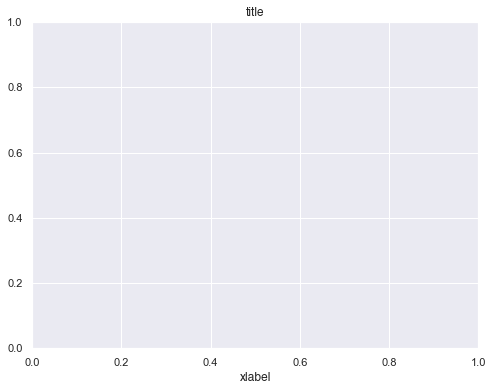

In [32]:
#plot configuration
CB91_Blue = '#2CBDFE'
CB91_Green = '#47DBCD'
CB91_Pink = '#F3A0F2'
CB91_Purple = '#9D2EC5'
CB91_Violet = '#661D98'
CB91_Amber = '#F5B14C'

color_list = [CB91_Blue, CB91_Amber]

csfont = {'fontname':'Helvetica'}
hfont = {'fontname':'Helvetica'}

plt.title('title',**csfont)
plt.xlabel('xlabel', **hfont)
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_list)

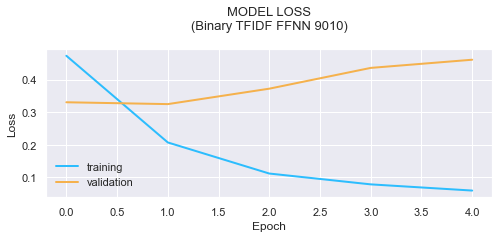

In [33]:
# plot loss during training
plt.subplot(212)
plt.title('MODEL LOSS\n(Binary TFIDF FFNN 9010)\n', fontsize = 13)
plt.plot(model_history.history['loss'], label='training', linewidth=2)
plt.plot(model_history.history['val_loss'], label='validation', linewidth=2)
plt.legend(frameon=False)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

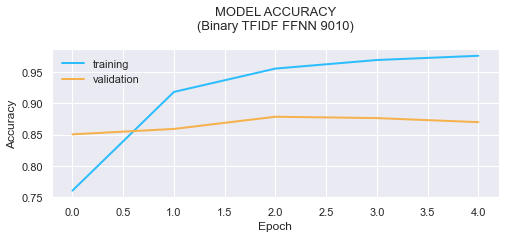

In [34]:
# plot accuracy during training
plt.subplot(212)
plt.title('MODEL ACCURACY\n(Binary TFIDF FFNN 9010)\n', fontsize = 13)
plt.plot(model_history.history['accuracy'], label='training', linewidth=2)
plt.plot(model_history.history['val_accuracy'], label='validation', linewidth=2)
plt.legend(frameon=False)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [35]:
#use predictions on test data
##### Step 6 - Use model to make predictions
# Predict class labels on training data
#pred_labels_train = (model.predict(x_train_vectorized) > 0.5).astype(int)
pred_labels_train = model.predict(x_train_vectorized)
# Predict class labels on a test data
#pred_labels_test = (model.predict(x_test_vectorized) > 0.5).astype(int)
pred_labels_test = model.predict(x_test_vectorized)

pred_labels_train_1 = []

pred_labels_test_1 = []

pred_labels_test_y = []

for i in range(len(pred_labels_train)):
    label = np.argmax(pred_labels_train[i])
    pred_labels_train_1.append(label)
    
for i in range(len(pred_labels_test)):
    label = np.argmax(pred_labels_test[i]) 
    pred_labels_test_1.append(label)
    pred_labels_test_y.append(pred_labels_test[i][label])
    
##### Step 7 - Model Performance Summary
print("")
print('-------------------- Model Summary --------------------\n')
model.summary() # print model summary
print("")
print('\n---------- Evaluation on Training Data ----------')
print(classification_report(np_train_y, pred_labels_train_1, digits=4))
print("")

print('\n---------- Evaluation on Test Data ----------')
print(classification_report(np_test_y, pred_labels_test_1, digits=4))
print("")

16/16 [==============================] - 0s 5ms/step

-------------------- Model Summary --------------------

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1000)              4925000   
                                                                 
 dropout_3 (Dropout)         (None, 1000)              0         
                                                                 
 dense_5 (Dense)             (None, 500)               500500    
                                                                 
 dropout_4 (Dropout)         (None, 500)               0         
                                                                 
 dense_6 (Dense)             (None, 50)                25050     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
         

[[211  46]
 [ 39 216]]


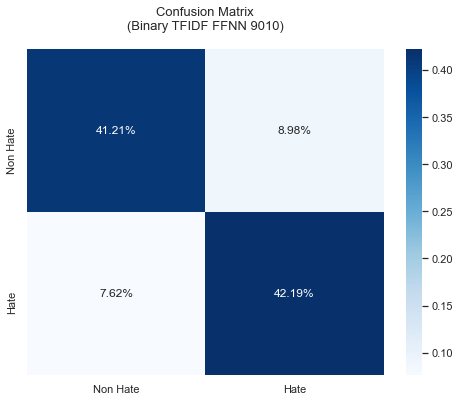

In [36]:
cf_matrix = confusion_matrix(np_test_y, pred_labels_test_1)
print(cf_matrix)
sns.set(rc={"figure.figsize":(8, 6)})
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, xticklabels = ['Non Hate', 'Hate'], yticklabels = ['Non Hate', 'Hate'],
            fmt='.2%', cmap='Blues')

plt.title('Confusion Matrix\n(Binary TFIDF FFNN 9010)\n', fontsize = 13) # title with fontsize 20
plt.show()

In [37]:
test_results = pd.DataFrame(list(zip(x_test,pred_labels_test_1, pred_labels_test_y)), columns = ['Tweet','Prediction', 'Prediction Value'])
test_results 

,Tweet,Prediction,Prediction Value
0,"[day, ends, balota, kiko, pangilinan, kasama]",0,0.999681
1,"[president, cutie]",0,1.000000
2,"[first, day, covid, pandemic, via, wow, vp, tr...",0,0.999829
3,"[presidente, bise, presidente, kiko, pangilini...",0,0.983980
4,"[dalawang, pangakong, binitiwan, sakaling, ibo...",0,0.999793
...,...,...,...
507,"[robredo's, final, speech, comelec's, presiden...",0,0.991915
508,"[sinungaling, umpisa, sinungaling, kahuli, hul...",1,1.000000
509,"[siniraan, pilipinas, last, six, years, wants,...",1,0.985040
510,"[manalo, matalo, kay, hganggang, dulo]",0,0.999960


In [38]:
#Saving labels to be used on other files
true_labels = open('true_labels.pkl', 'wb')
pickle.dump(np_test_y,true_labels)
true_labels.close()

predicted_labels = open('TFIDFFFNN_predicted_labels.pkl', 'wb')
pickle.dump(pred_labels_test_1,predicted_labels)
predicted_labels.close()

TFIDFFFNN_test_results = open('TFIDFFFNN_test_results.pkl', 'wb')
pickle.dump(test_results,TFIDFFFNN_test_results)
TFIDFFFNN_test_results.close()

In [ ]:
#test_predictions = (model.predict(x_test_vectorized) > 0.5).astype(int)

#test_prediction_labels = []

#for i in range(len(test_predictions)):
    
#    trueval = 'Non-hate'
    
#    if(test_y[i] == 1):
 #       trueval = 'Hate'
        
#    pred = 'Non-hate'
    
 #   if(test_predictions[i][1] == 1):
 #       pred = 'Hate'
    
  #  test_prediction_labels.append(pred)
  #  print("Sentence\n: "," ".join(str(item) for item in x_test[i]),"\n","True Value: ", trueval, "\nPred: ",pred, "\n~~~~~~~~~~~\n",sep="")

In [ ]:
#comparison_dataframe = pd.DataFrame(list(zip(x_test,y_test, test_prediction_labels)), columns = ['Tweet','True Label', 'Clasiification Label'])  

#with pd.option_context('display.max_rows', None,
#                       'display.max_columns', None,
 #                      'display.precision', 3,
  #                     ):
 #   display(comparison_dataframe)